In [1]:
import json
from models import Darknet
from train import hyp
from utils import torch_utils
from adapter import loss_func, get_y_func, load_voc, has_person, json_to_paths, create_split_func, YoloCategoryList
from utils.utils import compute_loss, build_targets
from fastai.vision import *

In [2]:
images = load_voc()

In [3]:
# Build lists of positive and negative samples
positive_samp = [img for img in images.values() if has_person(img)]
negative_samp = [img for img in images.values() if not has_person(img)]
f"{len(positive_samp)}; {len(negative_samp)}"

'8566; 12937'

In [4]:
# Truncate negative samples to be roughly same length as positive
negative_samp = negative_samp[:len(positive_samp)]
len(negative_samp)

8566

In [5]:
# Combine sample sets back together
samples = positive_samp #+ negative_samp

Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2070 with Max-Q Design', total_memory=7982MB)



In [7]:
# Load the model
img_size = (352, 608)
device = 'cuda:0'
arc = 'default'
cfg = 'cfg/yolov3-tiny-anchors.cfg'
# cfg = 'cfg/yolov3-tiny.cfg'
# weights = 'weights/ultralytics-trained-pascal-voc.pt'
weights = 'weights/best.pt'
device = torch_utils.select_device(device, apex=False, batch_size=64)
model = Darknet(cfg, img_size=img_size, arc=arc).to(device)
model.arc = 'default'
model.nc = 1  # num classes
model.hyp = hyp
model.load_state_dict(torch.load(weights, map_location=device)['model'])

# Build the paths and pass them to the FastAI ObjectItemList
posix_paths = json_to_paths(samples)
lst = ObjectItemList(posix_paths, label_cls=YoloCategoryList)
YoloCategoryList.anchors = [model.module_list[l].anchors for l in model.yolo_layers]
YoloCategoryList.img_size = img_size

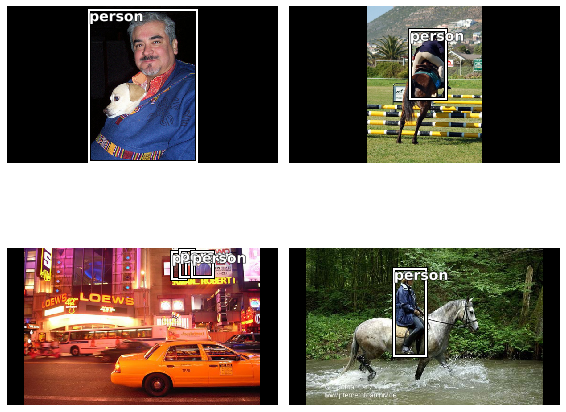

In [8]:
# Turn all this into a FastAI DataBunch so we can train
data = (lst
        .split_by_valid_func(create_split_func(samples))
        .label_from_func(partial(get_y_func, images))
        .transform(
            get_transforms(),
            tfm_y=True,
            size=img_size,
            resize_method=ResizeMethod.PAD,
            padding_mode='zeros'
        )
        .databunch(bs=16, collate_fn=bb_pad_collate))

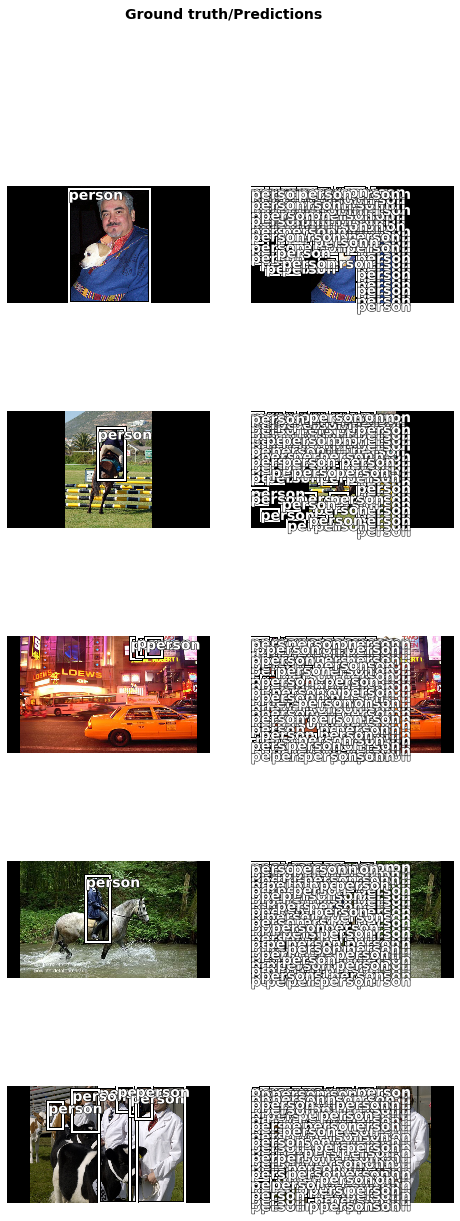

In [9]:
# Show the images so we can visually validate
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(8,8))


In [10]:
# Finally we have everything we need to make a learner
learner = Learner(data, model, loss_func=partial(loss_func, model))
learner.show_results()

In [11]:
# lr_find(learner)

In [12]:
# learner.recorder.plot()

epoch,train_loss,valid_loss,time
0,4.851326,4.599263,00:58


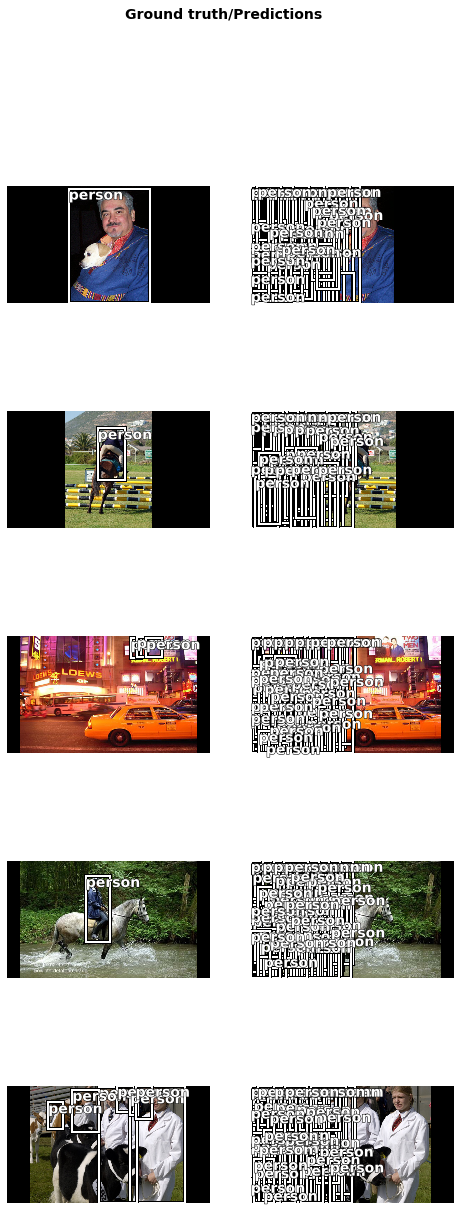

In [13]:
fit_one_cycle(learner, 1, max_lr=0.03)

In [ ]:
from utils.torch_utils import model_info
model_info(model)